In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
from tqdm import tqdm
import timm
import pandas as pd
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

c:\Users\nikita\anaconda3\envs\translator\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device selection
if torch.cuda.is_available():
    device = torch.device("cuda")
    num_workers = 0
    print("Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    num_workers = 0
    print("Using Apple MPS")
else:
    device = torch.device("cpu")
    num_workers = 2
    print("Using CPU")

Using CUDA


In [3]:
# Dataset
dataset = load_dataset("clane9/imagenet-100")

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class ImageNet100Dataset(Dataset):
    def __init__(self, ds, transform):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex["image"].convert("RGB")
        return self.transform(img), ex["label"]

train_ds = ImageNet100Dataset(dataset["train"], transform)
val_ds   = ImageNet100Dataset(dataset["validation"], transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False,
                        num_workers=num_workers, pin_memory=True)

# Load base model
base_model = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=100
)
base_model.load_state_dict(
    torch.load("vit_b16_imagenet100.pth", map_location="cpu")
)
base_model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [4]:
# Token Pruning Classes
class TokenPruner(nn.Module):
    def __init__(self, keep_ratio):
        super().__init__()
        self.keep_ratio = keep_ratio

    def forward(self, x):
        cls = x[:, :1]
        tokens = x[:, 1:]
        scores = tokens.norm(dim=-1)
        k = max(1, int(tokens.shape[1] * self.keep_ratio))
        idx = torch.topk(scores, k, dim=1).indices
        tokens = torch.gather(
            tokens, 1,
            idx.unsqueeze(-1).expand(-1, -1, tokens.size(-1))
        )
        return torch.cat([cls, tokens], dim=1)

class PrunedViT(nn.Module):
    def __init__(self, base_model, keep_ratio):
        super().__init__()
        self.base = base_model
        self.pruner = TokenPruner(keep_ratio)

    def forward(self, x):
        B = x.size(0)
        x = self.base.patch_embed(x)
        cls = self.base.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.base.pos_embed
        x = self.base.pos_drop(x)
        x = self.pruner(x)
        x = self.base.blocks(x)
        x = self.base.norm(x)
        return self.base.head(x[:, 0])


In [5]:

def measure_peak_memory(model):
    """Measure actual memory usage"""
    # Model parameter size
    param_mem = sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2
    
    if device.type == "cuda":
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        
        dummy = torch.randn(16, 3, 224, 224).to(device)
        with torch.no_grad():
            _ = model(dummy)
        
        gpu_mem = torch.cuda.max_memory_allocated() / 1024**2
        return param_mem, gpu_mem, f"{gpu_mem:.2f} MB (GPU peak)"
    
    else:
        # Estimate activation memory
        dummy = torch.randn(16, 3, 224, 224).to(device)
        with torch.no_grad():
            _ = model(dummy)
        
        return param_mem, param_mem, f"{param_mem:.2f} MB (params)"

In [6]:

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = total = 0
    preds, labels = [], []
    start = time.time()

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        p = out.argmax(dim=1)
        correct += (p == y).sum().item()
        total += y.size(0)
        preds.append(p.cpu())
        labels.append(y.cpu())

    latency = (time.time() - start) / total * 1000
    acc = 100 * correct / total
    f1 = f1_score(torch.cat(labels), torch.cat(preds), average="macro")
    throughput = 1000 / latency
    return acc, f1, latency, throughput

In [7]:
# Average tokens
@torch.no_grad()
def compute_avg_tokens(model):
    total_tokens = 0
    total_samples = 0

    for x, _ in val_loader:
        x = x.to(device)
        B = x.size(0)

        if hasattr(model, "base"):
            patch_embed = model.base.patch_embed(x)
            cls_token = model.base.cls_token.expand(B, -1, -1)
            pos_embed = model.base.pos_embed
            pos_drop = model.base.pos_drop
            pruner = model.pruner
        else:
            patch_embed = model.patch_embed(x)
            cls_token = model.cls_token.expand(B, -1, -1)
            pos_embed = model.pos_embed
            pos_drop = model.pos_drop
            pruner = None

        tokens = torch.cat([cls_token, patch_embed], dim=1)
        tokens = tokens + pos_embed
        tokens = pos_drop(tokens)

        if pruner is not None:
            tokens = pruner(tokens)

        total_tokens += tokens.size(1) * B
        total_samples += B

    return total_tokens / total_samples


In [8]:
# GFLOPs estimation
def estimate_vit_gflops_real(avg_tokens):
    D, L = 768, 12
    N = avg_tokens
    flops_attn = 3 * N * D * D + 2 * N * N * D
    flops_mlp = 2 * N * D * (4 * D)
    return L * (flops_attn + flops_mlp) / 1e9

# MAIN EXPERIMENT - MULTIPLE RATIOS
keep_ratios = [1.0, 0.8, 0.75, 0.5, 0.3]
results = []

print("\n" + "="*60)
print("STARTING EXPERIMENTS - MULTIPLE KEEP RATIOS")
print("="*60)

for ratio in keep_ratios:
    print(f"\n{'='*60}")
    print(f"Testing Keep Ratio: {ratio}")
    print(f"{'='*60}")

    if ratio == 1.0:
        model = base_model
        name = "Baseline"
        print("Using baseline model (no pruning)")
    else:
        # Create fresh base model for each ratio
        fresh_base = timm.create_model(
            "vit_base_patch16_224",
            pretrained=True,
            num_classes=100
        )
        fresh_base.load_state_dict(
            torch.load("vit_b16_imagenet100.pth", map_location="cpu")
        )
        
        model = PrunedViT(fresh_base, ratio).to(device)
        name = f"Pruned_{int(ratio*100)}"
        
        print(f"Fine-tuning pruned model (ratio={ratio})...")
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
        criterion = nn.CrossEntropyLoss()

        model.train()
        for epoch in range(1):  # Just 1 epoch for time
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/1")
            for x, y in loop:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()
                loop.set_postfix(loss=f"{loss.item():.4f}")
        
        # Save model
        torch.save({
            "state_dict": model.state_dict(),
            "keep_ratio": ratio
        }, f"vit_b16_pruned_{int(ratio*100)}.pth")
        print(f"Saved: vit_b16_pruned_{int(ratio*100)}.pth")

    # Evaluate
    print("Evaluating...")
    acc, f1, latency, throughput = evaluate(model, val_loader)
    param_mem, total_mem, mem_str = measure_peak_memory(model)
    avg_tokens = compute_avg_tokens(model)
    gflops = estimate_vit_gflops_real(avg_tokens)

    result = {
        "Model": name,
        "Keep Ratio": ratio,
        "Accuracy (%)": round(acc, 2),
        "F1 (macro)": round(f1, 4),
        "Latency (ms)": round(latency, 2),
        "Throughput (img/s)": round(throughput, 2),
        "Avg Tokens": round(avg_tokens, 2),
        "GFLOPs": round(gflops, 2),
        "Param Memory (MB)": round(param_mem, 2),
        "Peak Memory (MB)": round(total_mem, 2)
    }
    results.append(result)
    
    print(f"\nResults for {name}:")
    for k, v in result.items():
        print(f"  {k:20s}: {v}")

# Save results
df = pd.DataFrame(results)
print("\n" + "="*60)
print("FINAL RESULTS TABLE")
print("="*60)
print(df.to_string(index=False))
print("\n")

# Save to CSV
df.to_csv("pruning_results.csv", index=False)
print("Results saved to: pruning_results.csv")


STARTING EXPERIMENTS - MULTIPLE KEEP RATIOS

Testing Keep Ratio: 1.0
Using baseline model (no pruning)
Evaluating...

Results for Baseline:
  Model               : Baseline
  Keep Ratio          : 1.0
  Accuracy (%)        : 77.86
  F1 (macro)          : 0.7803
  Latency (ms)        : 12.37
  Throughput (img/s)  : 80.81
  Avg Tokens          : 197.0
  GFLOPs              : 16.05
  Param Memory (MB)   : 327.59
  Peak Memory (MB)    : 456.34

Testing Keep Ratio: 0.8
Fine-tuning pruned model (ratio=0.8)...


Epoch 1/1: 100%|██████████| 7919/7919 [55:47<00:00,  2.37it/s, loss=0.0000]


Saved: vit_b16_pruned_80.pth
Evaluating...

Results for Pruned_80:
  Model               : Pruned_80
  Keep Ratio          : 0.8
  Accuracy (%)        : 75.24
  F1 (macro)          : 0.7541
  Latency (ms)        : 12.32
  Throughput (img/s)  : 81.17
  Avg Tokens          : 157.0
  GFLOPs              : 12.68
  Param Memory (MB)   : 327.59
  Peak Memory (MB)    : 1761.0

Testing Keep Ratio: 0.75
Fine-tuning pruned model (ratio=0.75)...


Epoch 1/1: 100%|██████████| 7919/7919 [50:33<00:00,  2.61it/s, loss=0.0000]


Saved: vit_b16_pruned_75.pth
Evaluating...

Results for Pruned_75:
  Model               : Pruned_75
  Keep Ratio          : 0.75
  Accuracy (%)        : 75.22
  F1 (macro)          : 0.7523
  Latency (ms)        : 10.18
  Throughput (img/s)  : 98.26
  Avg Tokens          : 148.0
  GFLOPs              : 11.93
  Param Memory (MB)   : 327.59
  Peak Memory (MB)    : 2091.48

Testing Keep Ratio: 0.5
Fine-tuning pruned model (ratio=0.5)...


Epoch 1/1: 100%|██████████| 7919/7919 [40:40<00:00,  3.25it/s, loss=0.0005]


Saved: vit_b16_pruned_50.pth
Evaluating...

Results for Pruned_50:
  Model               : Pruned_50
  Keep Ratio          : 0.5
  Accuracy (%)        : 69.14
  F1 (macro)          : 0.6921
  Latency (ms)        : 10.61
  Throughput (img/s)  : 94.25
  Avg Tokens          : 99.0
  GFLOPs              : 7.89
  Param Memory (MB)   : 327.59
  Peak Memory (MB)    : 2054.98

Testing Keep Ratio: 0.3
Fine-tuning pruned model (ratio=0.3)...


Epoch 1/1: 100%|██████████| 7919/7919 [30:58<00:00,  4.26it/s, loss=1.0922]


Saved: vit_b16_pruned_30.pth
Evaluating...

Results for Pruned_30:
  Model               : Pruned_30
  Keep Ratio          : 0.3
  Accuracy (%)        : 61.54
  F1 (macro)          : 0.6132
  Latency (ms)        : 9.61
  Throughput (img/s)  : 104.1
  Avg Tokens          : 59.0
  GFLOPs              : 4.66
  Param Memory (MB)   : 327.59
  Peak Memory (MB)    : 2031.92

FINAL RESULTS TABLE
    Model  Keep Ratio  Accuracy (%)  F1 (macro)  Latency (ms)  Throughput (img/s)  Avg Tokens  GFLOPs  Param Memory (MB)  Peak Memory (MB)
 Baseline        1.00         77.86      0.7803         12.37               80.81       197.0   16.05             327.59            456.34
Pruned_80        0.80         75.24      0.7541         12.32               81.17       157.0   12.68             327.59           1761.00
Pruned_75        0.75         75.22      0.7523         10.18               98.26       148.0   11.93             327.59           2091.48
Pruned_50        0.50         69.14      0.6921      

Plot saved to: pruning_analysis.png


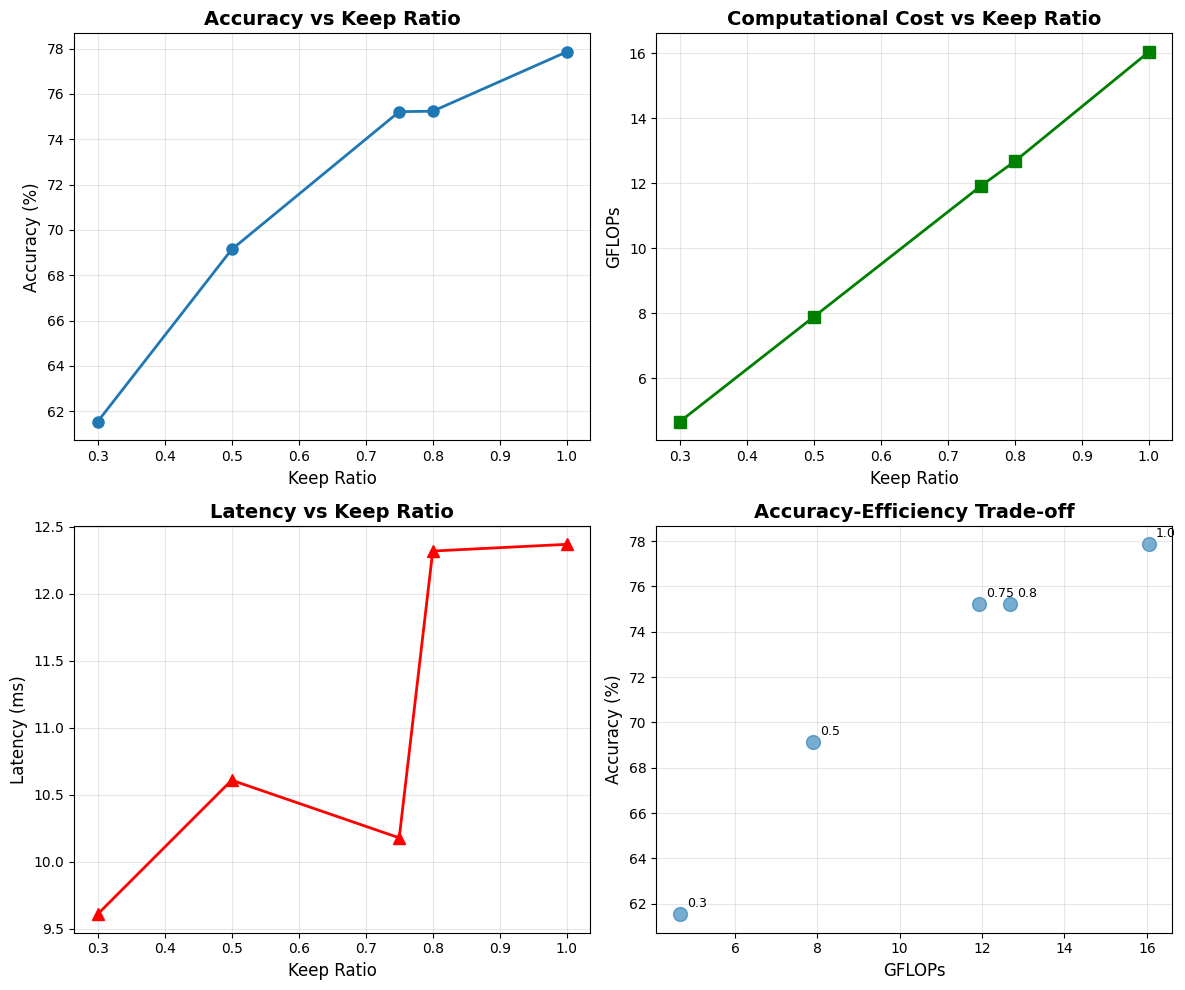


✅ ALL EXPERIMENTS COMPLETE!


In [9]:
# Create plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Accuracy vs Keep Ratio
axes[0, 0].plot(df['Keep Ratio'], df['Accuracy (%)'], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Keep Ratio', fontsize=12)
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 0].set_title('Accuracy vs Keep Ratio', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# GFLOPs vs Keep Ratio
axes[0, 1].plot(df['Keep Ratio'], df['GFLOPs'], marker='s', color='green', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Keep Ratio', fontsize=12)
axes[0, 1].set_ylabel('GFLOPs', fontsize=12)
axes[0, 1].set_title('Computational Cost vs Keep Ratio', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Latency vs Keep Ratio
axes[1, 0].plot(df['Keep Ratio'], df['Latency (ms)'], marker='^', color='red', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Keep Ratio', fontsize=12)
axes[1, 0].set_ylabel('Latency (ms)', fontsize=12)
axes[1, 0].set_title('Latency vs Keep Ratio', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Accuracy vs GFLOPs 
axes[1, 1].scatter(df['GFLOPs'], df['Accuracy (%)'], s=100, alpha=0.6)
for i, row in df.iterrows():
    axes[1, 1].annotate(f"{row['Keep Ratio']}", 
                        (row['GFLOPs'], row['Accuracy (%)']),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[1, 1].set_xlabel('GFLOPs', fontsize=12)
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 1].set_title('Accuracy-Efficiency Trade-off', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pruning_analysis.png', dpi=300, bbox_inches='tight')
print("Plot saved to: pruning_analysis.png")
plt.show()

print("\n✅ ALL EXPERIMENTS COMPLETE!")